# Hazard assessment for windstorms


- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [STORMS](https://github.com/CLIMAAX/STORMS) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

This event-based windstorm workflow can be used to see damages of a storm by combining hazard, exposure and vulnerability. The workflow is a simplified version of the work by [Koks & Haer (2020)](https://doi.org/10.1038/s41598-020-63580-w). 


## Hazard data

The hazard is represented by the storm footprint, a map with the maximum 3-second wind gust of a storm.

The workflow also demonstrates how to move historical storm footprints to different locations. This allows us to test the impact of storms happening further south of the original location. We do this because climate models suggest that future storms are likely to shift further north.

## Preparation work

### Load libraries

`````{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

In this notebook we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [zipfile](https://docs.python.org/3/library/zipfile.html#zipfile-objects) - To download and unzip the data
- [xarray](https://docs.xarray.dev/en/stable/) - To process the data and prepare it for damage calculation
- [matplotlib](https://matplotlib.org/) - To plot results
- [cdsapi](https://cds.climate.copernicus.eu/how-to-api) - To download data from the Copernicus Data Store 
- [geopandas](https://geopandas.org/en/stable/#) - To work with geospatial shapes
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) - To plot country borders
- [shapely](https://shapely.readthedocs.io/en/stable/index.html#) - To convert coordinates of area to a shape that can be plotted 

These libraries collectively enable the download, processing, analysis, and visualization of geospatial and numerical data, making them crucial for this risk workflow.
`````

In [1]:
import os
import zipfile

import xarray as xr
import matplotlib.pyplot as plt
import cdsapi
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box

### Select area of interest
Before downloading the data, we will define the coordinates of the area of interest. Based on these coordinates we will be able to clip the datasets for further processing, and eventually display hazard and damage maps for the selected area.

To easily define an area in terms of geographical coordinates, you can go to the [Bounding Box Tool](https://boundingbox.klokantech.com/) to select a region and get the coordinates. Make sure to select 'CSV' in the lower left corner and copy the values in the brackets below. Next to coordinates, please specify a name for the area which will be used in plots and saved results.

In [2]:
# specify the coordinates of the bounding box
bbox = [-8.811, 42.6647, -7.1524, 43.8009]
# name the area for saving datasets and plots
areaname = 'DeLugo_Spain'

# Examples:
#bbox = [-1.6,46,-1.05,46.4]; areaname = 'La_Rochelle'
#bbox = [1.983871,41.252461,2.270614,41.449569]; areaname = 'Barcelona'
#bbox = [12.1,45.1,12.6,45.7]; areaname = 'Venice'
#bbox = [-9.250441,38.354403,-8.618666,38.604761]; areaname = 'Setubal'

### Create the directory structure
In order for this workflow to work even if you download and use just this notebook, we need to set up the directory structure.  
Next cell will create the directory called 'STORM_event_raster' in the same directory where this notebook is saved.

In [3]:
# Define the folder for the storm workflow
workflow_folder = 'STORM_event_raster'

# Check if the workflow folder exists, if not, create it
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

general_data_folder = os.path.join(workflow_folder, 'general_data')

# Check if the general data folder exists, if not, create it
os.makedirs(general_data_folder, exist_ok=True)

In [4]:
# Define directories for data and plots within the previously defined workflow folder
data_dir = os.path.join(workflow_folder, f'data_{areaname}')
plot_dir = os.path.join(workflow_folder, f'plots_{areaname}')

os.makedirs(data_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

## Obtain the storm footprint for a single event

First we need the information on the hazard we want to analyse.

Choose one of the implemented options for retrieving the required storm footprint data (or implement your own):

- [Download prepared historical storm footprints](#option-a-download-prepared-historical-storm-footprints) (downscaled to 0.016° resolution, only events from a given catalogue)
- [Compute storm footprint from ERA5 hourly data](#option-b-compute-storm-footprint-from-era5-hourly-data) (coarse 0.25° resolution, flexible event selection)

Other sources of storm footprint data (maximum 10 m wind gust over a period covering the storm) can be utilized in the workflow.
E.g., you might be able to access gridded observations from your local meteorological service to run the analysis with.

### Option A: Download prepared historical storm footprints

We will access data from a historical [windstorm dataset](https://doi.org/10.24381/bf1f06a9) on the Climate Data Store.

Use the interactive "Download data" form on CDS to see the available dates.
You can also use the provided [windstorm selection helper](Selection_helper_STORMS.ipynb) to look for suitable events for your location of interest.

Data can be downloaded via the form on the website or with the code below from the API of the Climate Data Store.
  See the [CDS user guide](https://cds.climate.copernicus.eu/user-guide) for more information on data access and the configuration of the cdsapi client.

In [5]:
# Example configuration: download data for a storm in Spain
year = '2009'
month = '01'
day = '22'

storm_name = 'Klaus'

In [6]:
URL = 'https://cds.climate.copernicus.eu/api'
KEY = None  # specify your key if required
c = cdsapi.Client(url=URL, key=KEY)

zip_path_download = c.retrieve(
    'sis-european-wind-storm-reanalysis',
    {
        'product': 'windstorm_footprint',
        'variable': 'all',
        'tracking_algorithm': ['hodges'],  # alternative: 'tempestextremes'
        'event_aggregation': 'single_event',
        'windstorm_footprint_resolution': 'downscaled',
        'spatial_extent': 'full_domain',
        'year': [year],
        'month': [month],
        'day': [day]
    },
    os.path.join(general_data_folder, f'{storm_name}.zip')
)

# Extract content from downloaded archive then delete the archive
with zipfile.ZipFile(zip_path_download, 'r') as zObject:
    zObject.extractall(path=general_data_folder)
os.remove(zip_path_download)

To check the dataset we open the file

Text(0.5, 1.0, 'Windstorm across Europe')

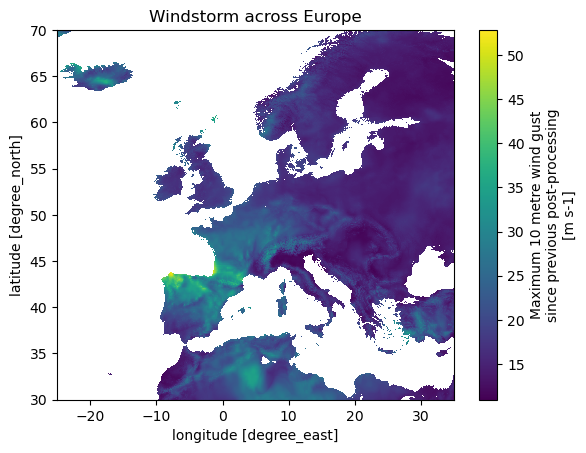

In [7]:
windstorm_europe = xr.open_mfdataset(
    os.path.join(general_data_folder, f"storm_footprint-*-{year}{month}{day}-*.nc")
)

# Dataset should contain a single event, squeeze out the track_id dimension.
# Also set up the coordinate reference system for rioxarray operations.
windstorm_europe = (
    windstorm_europe["footprint"]
    .squeeze()
    .rename({'latitude': 'y', 'longitude': 'x'})
    .rio.set_spatial_dims(x_dim="x", y_dim="y")
    .rio.write_crs(4326, inplace=True)
)

# Create a quick plot
windstorm_europe.plot()
plt.title('Windstorm across Europe')

In the plot above you can see the high windspeeds of the storm light up in yellow across Europe and especially the northwest of the Iberian peninsula.

Now we will clip the dataset to a wider area around the region of interest, and call it `windstorm_region`. The clipping of the dataset allows us to reduce the total size of the dataset so that it can be loaded into memory for faster processing and plotting.

In [8]:
windstorm_region = windstorm_europe.rio.clip_box(*bbox, crs="EPSG:4326")

# Save the data as a NetCDF file
windstorm_region.to_netcdf(os.path.join(data_dir, f'{storm_name}.nc'))

### Option B: Compute storm footprint from ERA5 hourly data

Aggregate wind gust data from the global [ERA5 reanalysis](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels?tab=overview) into a storm footprint.

The continous temporal coverage of ERA5 (1940-present) does not restrict us to using events from a predefined catalogue.
However, the basic ERA5 data has a much coarser resolution compared to a downscaled dataset as accessed in Option A.
We also expect that ERA5 underestimates the actual wind gusts when compared to observations.

:::{warning}

In general, we do not recommend to run the [risk assessment](Risk_assessment_STORMS.ipynb) notebook with hazard data at a resolution as low as the 0.25° of ERA5.
We suggest to use this option only to explore events not in the event catalogue accessed in Option A and to follow up with a dataset that better represents the local conditions.
Check, e.g., if your local meteorological service offers gridded observations of wind gusts that can be processed into a storm footprint.
:::

In [ ]:
# Label used for file names and captions
storm_name = "Klaus"

# Define the time period of the storm
storm_start = "2009-01-22 00:00"
storm_end = "2009-01-25 00:00"

# Generate file names for outputs
era5_gust_file = os.path.join(general_data_folder, f"{storm_name}_ERA5.nc")
footprint_file = os.path.join(data_dir, f"{storm_name}.nc")

Request hourly wind gust data from CDS:

In [ ]:
URL = 'https://cds.climate.copernicus.eu/api'
KEY = None  # add your own
c = cdsapi.Client(url=URL, key=KEY)

timesteps = pd.date_range(storm_start, storm_end, freq="1h")

c.retrieve("reanalysis-era5-single-levels", {
    "product_type": ["reanalysis"],
    "variable": ["10m_wind_gust_since_previous_post_processing"],
    "year": timesteps.year.unique().tolist(),  # pylint: disable=no-member
    "month": timesteps.month.unique().tolist(),  # pylint: disable=no-member
    "day": timesteps.day.unique().tolist(),  # pylint: disable=no-member
    "time": timesteps.hour.unique().tolist(),  # pylint: disable=no-member
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [bbox[3], bbox[0], bbox[1], bbox[2]]  # CDS order: NWSE
}).download(era5_gust_file)

Load the data for the selected period:

In [ ]:
gust_data = xr.open_dataarray(era5_gust_file).sel({
    "valid_time": slice(storm_start, storm_end)
})

Compute the storm footprint and add spatial reference information:

In [ ]:
windstorm_region = (
    gust_data
    .max(dim="valid_time")  # compute footprint
    .rename("FX")
    .rename({"latitude": "y", "longitude": "x"})
    .rio.set_spatial_dims(x_dim="x", y_dim="y")
    .rio.write_crs("EPSG:4326")
    #.rio.clip(cfeature.LAND.geometries())  # optional: only keep data over land
)

# Save processed footprint to disk
windstorm_region.to_netcdf(footprint_file)

## Visualize storm footprint

The next cell loads previously processed data. Skip it if data is already loaded from the previous steps.

In [9]:
storm_name = "Klaus"  # set if loading existing data

windstorm_region = xr.open_dataarray(
    os.path.join(data_dir, f"{storm_name}.nc"),
    decode_coords="all"
)

In [10]:
windstorm_region.rio.resolution()

(0.016666666666666725, 0.01666666666666675)

Plot the loaded storm footprint:

Text(0.5, 1.0, 'Windstorm Klaus across the region')

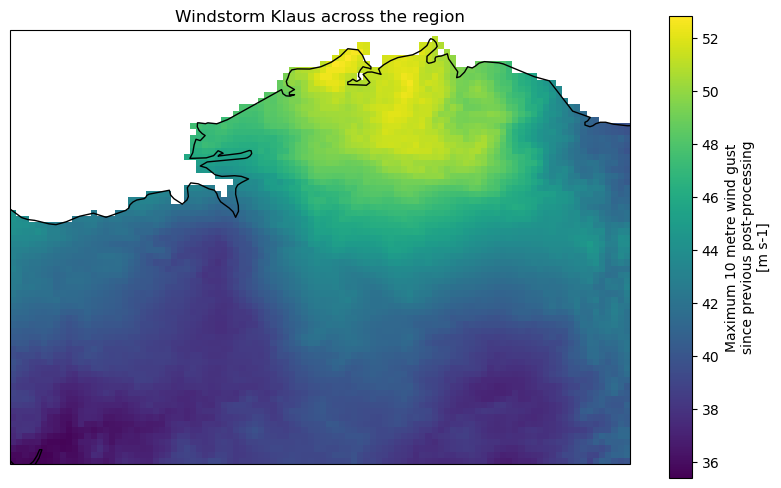

In [11]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})

windstorm_region.plot(ax=ax, transform=ccrs.PlateCarree())

ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.set_title(f'Windstorm {storm_name} across the region')

## Storm relocation

Here we will shift the storm footprint to a new location and save it for further use in the risk assement section worflow

In [12]:
# Calculate the current center of the footprint
current_center_lat = (windstorm_region['y'].min().item() + windstorm_region['y'].max().item()) / 2
current_center_lon = (windstorm_region['x'].min().item() + windstorm_region['x'].max().item()) / 2

print(f"Current center of footprint: Lat={current_center_lat}, Lon={current_center_lon}")

# Define the desired center (for example, coordinates in Southern France)
desired_center_lat = 43.499415 # Latitude, replace with your desired location
desired_center_lon = -1.4727   # Longitude, replace with your desired location

print(f"Desired center in France: Lat={desired_center_lat}, Lon={desired_center_lon}")

# Step 3: Calculate the translation vector (shift)
lat_shift = desired_center_lat - current_center_lat
lon_shift = desired_center_lon - current_center_lon

# Step 4: Apply the shift to the dataset
windstorm_region_shifted = windstorm_region.assign_coords(
    x=windstorm_region['x'] + lon_shift,  # Shift x (longitude) by lon_shift
    y=windstorm_region['y'] + lat_shift   # Shift y (latitude) by lat_shift
)

Current center of footprint: Lat=43.233333333333334, Lon=-7.983333333333334
Desired center in France: Lat=43.499415, Lon=-1.4727


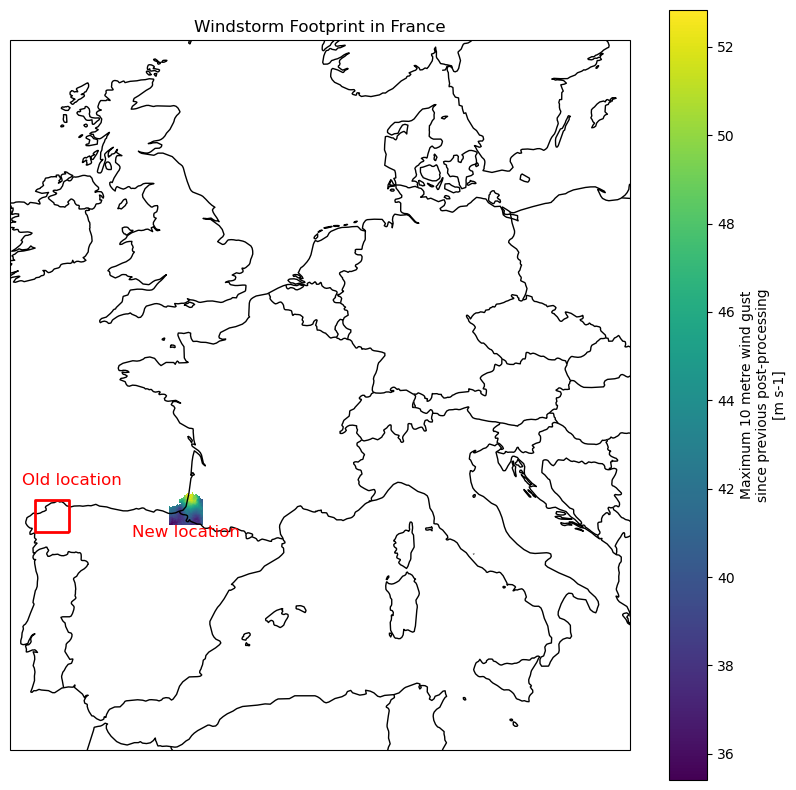

In [13]:
# Extract latitude and longitude coordinates from the shifted windstorm footprint data
lats = windstorm_region_shifted['x'].values  # Extract latitude values from the shifted data
lons = windstorm_region_shifted['y'].values  # Extract longitude values from the shifted data

# Create a plot of the European map with the updated windstorm footprint
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add geographic reference features such as coastlines and country borders
ax.coastlines()  # Add coastlines to the map for better geographic context
ax.add_feature(cfeature.BORDERS)  # Add country borders to the map

# Plot the shifted windstorm footprint on the map using the 'viridis' color map
windstorm_region_shifted.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', label='Moved windstorm footprint')

# Add a label indicating the new location of the windstorm footprint
plt.text(desired_center_lon, desired_center_lat - 1, 'New location', color='red', fontsize=12, ha='center')

# Set the extent of the map to focus on the region of interest (adjust limits as necessary)
ax.set_extent([-10, 20, 35, 60], crs=ccrs.PlateCarree())

# Add a title to the plot to describe the windstorm footprint location
plt.title('Windstorm Footprint in France')

# Plot the original bounding box of the windstorm footprint for comparison
bbox_old = gpd.GeoSeries([box(*bbox)], crs='EPSG:4326')  # Create a GeoSeries for the old bounding box
bbox_old.boundary.plot(ax=ax, color='red', linewidth=2)  # Plot the old bounding box with a red outline

# Add a label indicating the old location of the windstorm footprint
plt.text(current_center_lon + 1, current_center_lat + 1.1, 'Old location', color='red', fontsize=12, ha='center')

# Display the final plot
plt.show()


In [14]:
# save the foorprint
windstorm_region_shifted.to_netcdf(f'{data_dir}/{storm_name}_shifted.nc')

## Conclusions

In this hazard workflow we learned:
 - How to retrieve winstorm footprints for your specific region.
 - How to move winstorms more north to asses potential future hazards.
 
The regional windstorm map can now be used in the risk assessment workflow.

## Contributors

- Ted Buskop (Deltares & Vrije Universiteit Amsterdam, IVM)


## References

- Koks, E.E., Haer., T. A high-resolution wind damage model for Europe. Sci Rep 10, 6866 (2020). DOI: [10.1038/s41598-020-63580-w](https://doi.org/10.1038/s41598-020-63580-w)
- Copernicus Climate Change Service (2025): Windstorm tracks and footprints derived from reanalysis over Europe between 1940 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: [10.24381/bf1f06a9](https://doi.org/10.24381/bf1f06a9)